# Modèles de prédiction 

Je propose de résumer ici le travail d'exploration fait dans le premier notebook. 

L'objectif est de prédire deux variables numériques : la consommation d'énergie des bâtiments ```SiteEnergyUse(kBtu)```et la quantité d'émission de CO2 ```CO2_emissions```. Après différents pré-traitements tels que l'élimination des variables corrélées entres elles, ou la vectorisation des variables catégorielles, le jeu d'entrainement a la forme suivante : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


In [2]:
data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
print(len(data.columns[data.dtypes==float])-3, "training numerical variables")
print(len(data.columns[data.dtypes==int]), 
      "training interger variables (from tokenization of categorical variable)")
data.head()

6 training numerical variables
22 training interger variables (from tokenization of categorical variable)


,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,age_of_building,BuildingType_0,...,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7103895.25,249.705,88.5,0,...,0,0,0,0,0,0,0,0,0,1
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8371084.00,279.685,19.5,0,...,0,0,0,0,0,0,0,0,0,1
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,72858840.00,2075.380,46.5,0,...,0,0,0,0,0,0,0,0,0,1
3,58091.0,1.0,10.0,0.0,61320.0,28.5,17511952.00,1111.385,89.5,0,...,0,0,0,0,0,0,0,0,0,1
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,14500852.50,506.355,35.5,0,...,0,0,0,0,0,0,0,0,0,1


# Mise à l'écart de l'ensemble de test : 
Je mets de côté l'ensemble de test, sur lequel je comparerai mes modèles prédictifs à la fin. 

### Séparation données d'entrainement

In [3]:
from sklearn.model_selection import train_test_split

X_original = data.drop(["SiteEnergyUse(kBtu)","CO2_emissions", "ENERGYSTARScore"], axis = 1)
y_original = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, train_size=0.8)

index_train = y_original_train.index
index_test = y_original_test.index

Par soucis de clarté de code, je vais renommer $X\_original\_train$ avec $X$. **Ainsi, le lecteur pourra bien comprendre que le $X$ évoqué dans la suite sera bien l'ensemble d'entrainement.**

In [4]:
X = X_original_train
y = y_original_train

### Standardisation entrainée sur l'ensemble d'entrainement

In [5]:
from sklearn import preprocessing
my_standardizer = preprocessing.StandardScaler()
my_standardizer.fit(X_original_train)

X_std = pd.DataFrame(my_standardizer.transform(X), columns=X.columns, index = X.index)
X_original_test_std = my_standardizer.transform(X_original_test)

## std y ?
my_standardizer.fit(y_original_train)

y_std = pd.DataFrame(my_standardizer.transform(y), columns = y.columns, index = y.index)
y_original_test_std = my_standardizer.transform(y_original_test)

In [6]:
from multivariate_analysis import *
from sklearn.model_selection import RepeatedKFold

X_ = X_std.copy()
y_ = y_std["SiteEnergyUse(kBtu)"].copy()
my_meth = linear_model.LinearRegression(fit_intercept = True,normalize = True)
cv = 5
def pseudo_cv_without_paramgrid(X_, y_, my_meth, cv = 5):
    ## init
    k = 1
    res = {} # dict of dict 
    kf = RepeatedKFold(n_splits = cv, n_repeats=1)
    ## loop on folds
    for train_range_index, test_range_index in kf.split(X = X_.values, y = y_.values) : 
        train_index = y_.index[train_range_index].values
        test_index = y_.index[test_range_index].values

        ## GET X and y SPLIT : 
        CV_X_train, CV_X_test = X_.loc[train_index,:], X_.loc[test_index,:]
        CV_y_train, CV_y_test = y_.loc[train_index], y_.loc[test_index]

        fold_key = "fold"+str(k)
        k+=1

        my_meth.fit(CV_X_train,CV_y_train) 
        y_pred = my_meth.predict(CV_X_test)
        y_table = pd.DataFrame(np.matrix((y_pred, CV_y_test)).T, columns=["pred","real"])
        res[fold_key] = y_table
    return(res)

from sklearn import metrics
def compute_R2(table):
    return(metrics.r2_score(y_true = table.real, y_pred=table.pred))

def get_score_from_pseudo_CV(dict_y_table, cv = 5):
    score = []
#     dict_y_table = pseudo_cv_without_paramgrid(X_, y_, my_meth, cv = 5)
    for y_table in dict_y_table.values():
        score.append(compute_R2(y_table))
    return(score)

In [7]:
def compare_regressions(X_, y_, dict_lr_model, dict_param_grid, score_name="r2", fig_name=None):    
    X_ = X_.copy()
    y_ = y_.copy()
    ## init save res :
    min_score = {}
    max_score = {}
    res = pd.DataFrame(columns=["score", "execution_time", "best_alpha"])
    dict_lr_model = dict_lr_model.copy()

    ## SIMPLE LINEAR REGRESSION  :
    my_meth = linear_model.LinearRegression(fit_intercept = True,normalize = True)
    res.at["lr", :] = np.nan
    time_ref = time.time()
    pseudo_cv_lr = pseudo_cv_without_paramgrid(X_, y_,my_meth, cv = 5)
    res.at["lr", "execution_time"] = (time.time() - time_ref)/5
    list_of_scores = get_score_from_pseudo_CV(pseudo_cv_lr)
    ## I remove aberrant r2 (probably due to outliers)
    score_lr = np.mean([score >0 for score in list_of_scores])
    res.at["lr", "score" ] = score_lr
    if abs(score_lr)>1 :
        score_lr = 0
    res.at["lr","best_alpha"]=None
    min_score["lr"] = score_lr
    max_score["lr"] = score_lr
    
    # LOOP ON REG ON lr_model_list 
    for model_name,lr_model in dict_lr_model.items():
        alpha_values = dict_param_grid[model_name]
        CV,execution_time = launch_cv(model_name,lr_model,alpha_values,X_,y_)
        ## extract CV results in dictionnaries :
        res.at[model_name,"score"] = CV.cv_results_['mean_test_score'].mean()
        best_alpha = CV.best_params_["alpha"]
        res.at[model_name,"best_alpha"] = best_alpha
        res.at[model_name,"execution_time"] = execution_time
        ## plot references : 
        min_score[model_name] = min(CV.cv_results_['mean_test_score'])
        max_score[model_name] = max(CV.cv_results_['mean_test_score'])
        ## plot scoring : 
        plot_score(alpha_values, CV.cv_results_['mean_test_score'], model_name, best_alpha, score_name)
        ## reset params in model
        dict_lr_model[model_name].set_params(**{"alpha":None})
    ## add linear regression R2 line : 
    min_alpha = min([min(arr) for arr in dict_param_grid.values()])
    max_alpha = max([max(arr) for arr in dict_param_grid.values()])
    plt.plot([min_alpha,max_alpha], [score_lr, score_lr], label = "linear regression")
    # plt.ylim([-0.1,1])
    plt.ylim([1.1*min(min_score.values())-0.05, 1.1*max(max_score.values())+0.05])
    plt.xlim([min_alpha,max_alpha])
    plt.legend()
    if fig_name is not None : 
        figname = fig_name + "compare_regression"
        plt.savefig(res_path+"figures/"+figname+".jpg")
    return(res)


for SiteEnergyUse(kBtu) in log space :


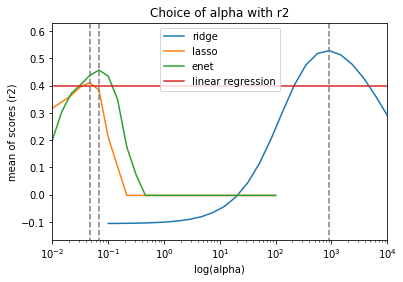

,score,execution_time,best_alpha
lr,0.4,0.020715,None
ridge,0.146277,0.332089,908.517576
lasso,0.099345,0.272646,0.046416
enet,0.126706,0.281547,0.068129


In [10]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
               "enet" : linear_model.ElasticNet(),
              }

var = "SiteEnergyUse(kBtu)"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

for CO2_emissions in log space :


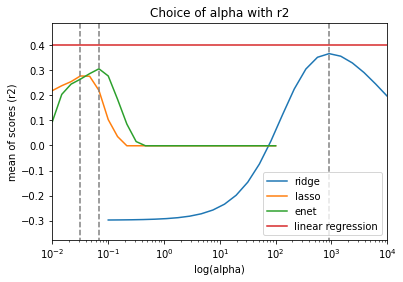

,score,execution_time,best_alpha
lr,0.4,0.009613,None
ridge,-0.028653,0.254808,908.517576
lasso,0.064107,0.306187,0.031623
enet,0.077806,0.197812,0.068129


In [11]:
var = "CO2_emissions"
X_ = X_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

La régression linéaire, même avec pénalisation, ne semble pas produire un modèle de prédiction convainquant, notamment à cause de la lourde queue de distribution des variables à prédire. Néansmoins, je vais utiliser la régression pénalisée lasso sur les variables "catégorielles" (issues de la vectorisation de ces dernière pour être précise), afin de voir si certaines de mes modalités sont non significatives (et peuvent donc être retirées).

for SiteEnergyUse(kBtu) in log space :


/home/clairegayral/.env_python/openclassroom/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023948116685858167, tolerance: 0.019160812634971713
  model = cd_fast.enet_coordinate_descent(


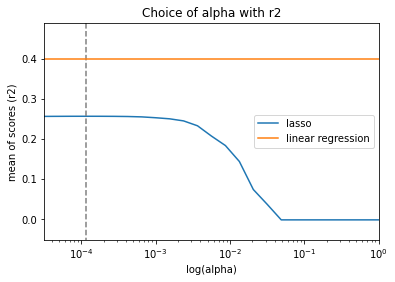

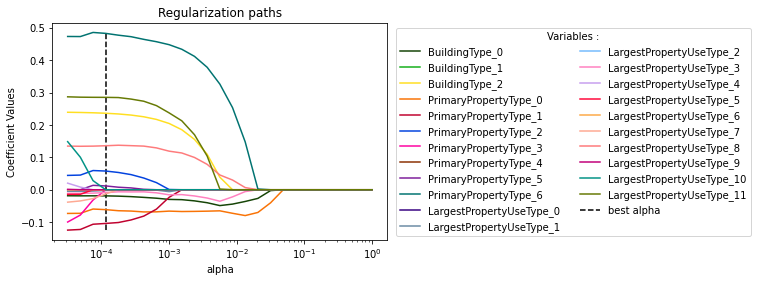

,score,execution_time,best_alpha
lr,0.4,0.016054,None
lasso,0.14594,0.398668,0.000115


In [25]:
dict_models = {"lasso" : linear_model.Lasso()}
dict_param_grid = {"lasso": np.logspace(-4.5, 0, 25)}

var = "SiteEnergyUse(kBtu)"
X_ = X.loc[:,X.dtypes == int]
y_ = np.log(y_std[var]+1)

print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
## regul paths :
model_name = "lasso"
legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.1, 1), "ncol":2}
plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                 X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                 var_names = X_.columns, legend_kwargs=legend_kwargs)
plt.show()
res